In [10]:
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
import scipy.stats
import os
import scipy.io as sio
import scipy.ndimage
import dnatools2
%matplotlib inline
from pylab import *

# Plotting Params:
rc('mathtext', default='regular')
fsize=20

### Make directory to save results:

In [2]:
resultsdir = '../results/N7_A5SS_Model_Predictions/'
if not os.path.exists(resultsdir):
    os.makedirs(resultsdir)
figdir = '../figures/N7_A5SS_Model_Predictions/'
if not os.path.exists(figdir):
    os.makedirs(figdir)
    
#Choose if you want to actually save the plots:
SAVEFIGS = False

### Load data:

In [3]:
data = sio.loadmat('rosen/cell-2015-master/data/Reads.mat')
# A5SS
A5SS_data = data['A5SS']
A5SS_reads = np.array(A5SS_data.sum(1)).flatten()
A5SS_data = np.array(A5SS_data.todense())
# Get minigenes with reads
A5SS_nn = find(A5SS_data.sum(axis=1))
A5SS_reads = A5SS_reads[A5SS_nn]
A5SS_data = A5SS_data[A5SS_nn]
A5SS_data = A5SS_data/A5SS_data.sum(axis=1)[:,newaxis]
A5SS_seqs = pd.read_csv('rosen/cell-2015-master/data/A5SS_Seqs.csv',index_col=0).Seq[A5SS_nn]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  import sys


In [11]:
def make_padded_nmer_matrix(seqs,mer_len):
    mer_dict = dict(zip(dnatools2.make_mer_list(6),range(4**6)))
    rows,cols,vals = [],[],[]
    for i in xrange(len(seqs)):
        cur_seq = A5SS_seqs[i]
        for b in range(7-mer_len,32)+range(50-mer_len,75):
            cur_mer = cur_seq[b:b+mer_len]
            cur_mer_list_pos = mer_dict[cur_mer]
            rows.append(i)
            cols.append(cur_mer_list_pos+4**mer_len*(b+80))
            vals.append(1)
        if(i%10000)==0:
            print i,
            
        # Add a zero to the bottom right of the matrix to ensure the
        # correct size
        rows.append(len(A5SS_data)-1)
        cols.append(4**6*230-1)
        vals.append(0)
    X = scipy.sparse.csr_matrix((vals,(rows,cols)))
    return X

In [12]:
X = make_padded_nmer_matrix(A5SS_seqs.values,6)

0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000


Save the matrix with the splice donor usage into a .mat file:

In [13]:
# Only include the first 80 positions and the the last position (unspliced)
Y = scipy.matrix(A5SS_data)
Y = scipy.hstack((Y[:,:80],Y[:,-1:]))

### Testing the model with a small amount of data

Now that this is saved I have a script that we can use to train the model. (Warning: the script works, but is hacked together and probably very hard to understand. If there is interest, I can clean it up.)

In [1]:
from keras.models import load_model
from pkg_resources import resource_filename
from spliceai.utils import one_hot_encode
import numpy as np

a5ss_full='atggtgtccaagggcgaggagctgttcaccggggtggtgcccatcctggtcgagctggacggcgacgtaaacggccacaagttcagcgtcagcggcgagggcgagggcgatgccacctacggcaaactgaccctgaagttcatctgcaccaccggcaagctgcccgtgccctggcccaccctcgtgaccaccttcggctacggcctgatgtgcttcgcccgctaccccgaccacatgaagcagcacgacttcttcaagtccgccatgcccgaaggctacgtccaggagcgcaccatcttcttcaaggacgacggcaactacaagacccgcgccgaagtgaagttcgagggcgacaccctcgtgaaccgcatcgagctaaagggcatcgacttcaaggaggacggcaacatcctggggcacaagctggagtacaactacaacagccacaacgtctatatcatggccgacaagcagaagaacggcatcaaagtgaacttcaagatccgccacaacatcgaggtgcttggnnnnnnnnnnnnnnnnnnnnnnnnnggtcgacccaggttcgtgnnnnnnnnnnnnnnnnnnnnnnnnngaggtattcttatcaccttcgtggctacagagtttccttatttgtctctgttgccggcttatatggacaagcatatcacagccatttatcggagcgcctccgtacacgctattatcggacgcctcgcgagatcaatacgtataccagctgccctcgatacatgtcttggcatcgtttgcttctcgagtactacctggttcctcttctttctttctcttctctttcaggacggcagcgtgcagctcgccgaccactaccagcagaacacccccatcggcgacggccccgtgctgctgcccgacaaccactacctgagctaccagtccgccctgagcaaagaccccaacgagaagcgcgatcacatggtcctgctggagttcgtgaccgccgccgggatcactctcggcatggacgagctgtacaagga'.upper()

context = 400
paths = ('joint_spliceai14.h5'.format(x) for x in range(1))
models = [load_model(resource_filename('spliceai', x)) for x in paths]

Using TensorFlow backend.


ImportError: No module named utils

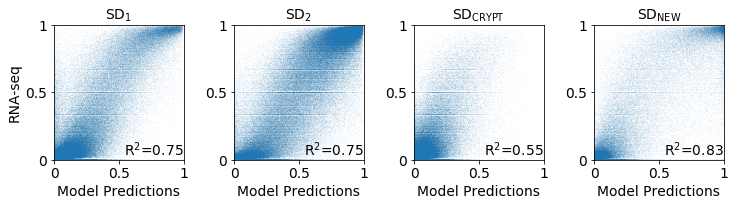

In [16]:
Y = np.array(Y)
a = 0.5
psize = .1
fsize = 13.85
rasterized_on = True
bins =50
axlim = [0,1,0,1]
hist_thresh = 300.

fig = figure(figsize=(10*1,1.875*1))
width=0.18
height = 1
#ax = fig.add_subplot(221)
ax = axes([0,0,width,height])
axis([0,1,0,1])
sd = 0
x,y = combined_predictions[:,sd],Y[:,sd]
scatter(x,y,s=psize,edgecolor='None',alpha = a,rasterized=rasterized_on)
z, xedge, yedge = np.histogram2d(y, x, bins=[bins, bins], 
                                    range=(axlim[:2],axlim[2:]))
z = scipy.ndimage.zoom(z, 3)
z[z<hist_thresh] = nan
#contourf(np.log(z), bins, cmap=cm.jet, extent=axlim)
ax.tick_params(labelsize=fsize)
ax.set_xticks([0,0.5,1])
ax.set_xticklabels(['0','0.5','1'])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels(['0','0.5','1'])
#title('$SD_1$',fontsize=fsize)
#xlabel('Predicted',fontsize=fsize)
#ylabel('RNA-seq',fontsize=fsize)
text(1,0.03,'$R^2$=%.2f' %(scipy.stats.pearsonr(x,y)[0]**2),fontsize=fsize,ha='right')
ax.set_title('$SD_1$',fontsize=fsize)
ax.set_ylabel('RNA-seq',fontsize=fsize)
ax.set_xlabel('Model Predictions',fontsize=fsize)

ax = axes([0.25,0,width,height])
axis([0,1,0,1])
sd = 44
x,y = combined_predictions[:,sd],Y[:,sd]
scatter(x,y,s=psize,edgecolor='None',alpha = a,rasterized=rasterized_on)
z, xedge, yedge = np.histogram2d(y, x, bins=[bins, bins], 
                                    range=(axlim[:2],axlim[2:]))
z = scipy.ndimage.zoom(z, 3)
z[z<hist_thresh] = nan
#contourf(np.log(z), bins, cmap=cm.jet, extent=axlim)
ax.tick_params(labelsize=fsize)
ax.set_xticks([0,0.5,1])
ax.set_xticklabels(['0','0.5','1'])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels(['0','0.5','1'])
#title('$SD_{2}$',fontsize=fsize)
#xlabel('Predicted',fontsize=fsize)
#ylabel('RNA-seq',fontsize=fsize)
text(1,0.03,'$R^2$=%.2f' %(scipy.stats.pearsonr(x,y)[0]**2),fontsize=fsize,ha='right')
ax.set_title('$SD_2$',fontsize=fsize)
ax.set_xlabel('Model Predictions',fontsize=fsize)


ax = axes([0.5,0,width,height])
axis([0,1,0,1])
sd = 79
x,y = combined_predictions[:,sd],Y[:,sd]
scatter(x,y,s=psize,edgecolor='None',alpha = a,rasterized=rasterized_on)
z, xedge, yedge = np.histogram2d(y, x, bins=[bins, bins], 
                                    range=(axlim[:2],axlim[2:]))
z = scipy.ndimage.zoom(z, 3)
z[z<hist_thresh] = nan
#contourf(np.log(z), bins, cmap=cm.jet, extent=axlim)
ax.tick_params(labelsize=fsize)
ax.set_xticks([0,0.5,1])
ax.set_xticklabels(['0','0.5','1'])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels(['0','0.5','1'])
#title('$SD_{3}$',fontsize=fsize)
#xlabel('Predicted',fontsize=fsize)
#ylabel('RNA-seq',fontsize=fsize)
text(1,0.03,'$R^2$=%.2f' %(scipy.stats.pearsonr(x,y)[0]**2),fontsize=fsize,ha='right')
ax.set_title('$SD_{CRYPT}$',fontsize=fsize)
ax.set_xlabel('Model Predictions',fontsize=fsize)


ax = axes([0.75,0,width,height])
axis([0,1,0,1])
sd = 'other'
x = sum(combined_predictions[:,5:35],axis=1) + sum(combined_predictions[:,48:77],axis=1)
y = sum(Y[:,5:35],axis=1) + sum(Y[:,48:77],axis=1)
scatter(x,y,s=psize,edgecolor='None',alpha = a,rasterized=rasterized_on)
z, xedge, yedge = np.histogram2d(y, x, bins=[bins, bins], 
                                    range=(axlim[:2],axlim[2:]))
z = scipy.ndimage.zoom(z, 3)
z[z<hist_thresh] = nan
#contourf(np.log(z), bins, cmap=cm.jet, extent=axlim)
ax.tick_params(labelsize=fsize)
ax.set_xticks([0,0.5,1])
ax.set_xticklabels(['0','0.5','1'])
ax.set_yticks([0,0.5,1])
ax.set_yticklabels(['0','0.5','1'])
#title('$SD_{3}$',fontsize=fsize)
#xlabel('Predicted',fontsize=fsize)
#ylabel('RNA-seq',fontsize=fsize)
text(1,0.03,'$R^2$=%.2f' %(scipy.stats.pearsonr(x,y)[0]**2),fontsize=fsize,ha='right',)
ax.set_title('$SD_{NEW}$',fontsize=fsize)
ax.set_xlabel('Model Predictions',fontsize=fsize)

if SAVEFIGS:
    filename = 'A5SS_Library_Prediction_Scatter'
    fig.savefig(figdir+filename+'.png', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+filename+'.eps', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+filename+'.pdf', bbox_inches='tight',dpi=300)

In [23]:
new_seq=a5ss_full[:520]+A5SS_seqs[0]+a5ss_full[621:]

In [20]:
A5SS_seqs.shape

(265044,)

In [24]:
new_seq

'ATGGTGTCCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTCAGCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAACTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCTTCGGCTACGGCCTGATGTGCTTCGCCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAAGTGAAGTTCGAGGGCGACACCCTCGTGAACCGCATCGAGCTAAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAAGTGAACTTCAAGATCCGCCACAACATCGAGGTGCTTGGTGAAGACAGAGAAAGAGAACCAAAAGGTCGACCCAGGTTCGTGAATCCGGTAACGCGGAGAGAATACAGAGGTATTCTTATCACCTTCGTGGCTACAGAGTTTCCTTATTTGTCTCTGTTGCCGGCTTATATGGACAAGCATATCACAGCCATTTATCGGAGCGCCTCCGTACACGCTATTATCGGACGCCTCGCGAGATCAATACGTATACCAGCTGCCCTCGATACATGTCTTGGCATCGTTTGCTTCTCGAGTACTACCTGGTTCCTCTTCTTTCTTTCTCTTCTCTTTCAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCTACCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTC

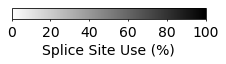

In [20]:
fig = figure(figsize=(3,1))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cm.gray_r,
                                   norm=norm,
                                   orientation='horizontal')
ax.xaxis.set_tick_params(labelsize=14)
ax.xaxis.set_ticks(arange(0,1.2,0.2))
ax.xaxis.set_ticklabels(arange(0,101,20))
ax.tick_params(size=2)
ax.set_xlabel('Splice Site Use (%)',fontsize=14)
if SAVEFIGS:
    name = 'SS Prediction Colorbar'
    fig.savefig(figdir+name+'.png', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+name+'.eps', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+name+'.pdf', bbox_inches='tight',dpi=300)

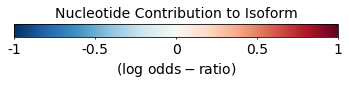

In [21]:
fig = figure(figsize=(5,1.25))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.15])
norm = mpl.colors.Normalize(vmin=-0.4, vmax=.4)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cm.RdBu_r,
                                   norm=norm,
                                   orientation='horizontal')
ax.xaxis.set_tick_params(labelsize=14)
ax.xaxis.set_ticks(arange(0,1.01,1/4.))
ax.xaxis.set_ticklabels([-1,-0.5,0,0.5,1])
ax.set_title('Nucleotide Contribution to Isoform',fontsize=14)
ax.set_xlabel('$(log\ odds-ratio)$',fontsize=14)
ax.tick_params(size=2)
if SAVEFIGS:
    name = 'Nucleotide_Contribution_Colorbar'
    fig.savefig(figdir+name+'.png', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+name+'.eps', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+name+'.pdf', bbox_inches='tight',dpi=300)

In [22]:
seqs = pd.Series(data=A5SS_seqs.values,index=range(len(A5SS_seqs)))

In [23]:
w = data['Mer_scores'][:4**6*8]
w_mat = w.reshape(4**6,size(w)/4**6)
mer6_dict = dict(zip(dnatools.make_mer_list(6),range(4**6)))
pos_map = dict(zip(range(-80,80),[0]*40+[1]*(40-9)+[-1]*6+[2,3,4,5]+[-1]*5+[6]*29+[7]*45))
def score_seq(seq,sd):
    scores = np.zeros(90)
    for b in range(2,32)+range(45,75):
        rel_pos = b-sd
        cur_mer = seq[b:b+6]
        cur_pos_ind = pos_map[rel_pos]
        if(cur_pos_ind>=0):
            scores[b+4:b+6+4] += w_mat[mer6_dict[cur_mer],cur_pos_ind]
    return scores

ValueError: cannot reshape array of size 32849 into shape (4096,8)

In [24]:
def convertT2U(seq):
    sU = ''
    for b in seq:
        if b=='T':
            sU += 'U'
        else:
            sU += b
    return sU

def make_nt_contribution_fig_4(num,savefig=False):
    pred_li = np.array([0.]*3+list(combined_predictions[num,:80])+[0.]*7)
    data_li = np.array([0.]*3+list(Y[num,:80])+[0.]*7)
    new_sds = set(find((np.array(pred_li)>0.05) | (np.array(data_li)>0.05)))-set([3,47,82,83])
    all_sds = sorted(list(new_sds.union(set([3,47,82]))))
    seq = seqs.values[num]
    
    all_weights = []
    for sd in all_sds:
        temp_weight_row = np.zeros(90)
        if(sd==3):
            temp_weight_row = score_seq(seq,0)
        elif(sd==47):
             temp_weight_row = score_seq(seq,44)
        elif(sd==82):
            temp_weight_row = score_seq(seq,79)
        else:
            temp_weight_row = score_seq(seq,sd-4)
        all_weights.append(temp_weight_row)
    all_weights = np.array(all_weights)
    
    fig = figure(figsize=(13.5,len(all_sds)/1.75))
    for i in range(len(all_sds)):
        ax = fig.add_axes((0,(len(all_sds)-i-1)/float(len(all_sds)),0.71,0.5/len(all_sds)))
        ax.imshow(np.array([all_weights[i],all_weights[i]]),interpolation='None',cmap=cm.RdBu_r,aspect=0.75,vmin=-1,vmax=1)
        ax.set_xticklabels([]);
        ax.set_yticklabels([]);
        ax.tick_params(size=0)
        cur_row =i
        cur_pos = all_sds[i]
        ax = fig.add_axes((0,(len(all_sds)-i-1+0.4)/float(len(all_sds)),0.71,0.5/len(all_sds)))
        ax.set_xticklabels([]);
        ax.set_yticklabels([]);
        ax.tick_params(size=0)
        box('off')
        rect1 = matplotlib.patches.Rectangle((0,0.1), cur_pos, .5, color=(0.2,0.2,0.2))
        ax.add_patch(rect1)
        ax.plot([cur_pos,90],[0.35,0.35],color=(0.2,0.2,0.2),linewidth=2)
        axis([0,90,0,1])
        if(i==0):
            ax.set_xticks(arange(90)+0.5)
            ax.set_xticklabels('GAGG'+convertT2U(seq))
            for tick in ax.get_xaxis().get_major_ticks():
                tick.set_pad(-5.)
            ax.xaxis.tick_top()
            ax.tick_params(labelsize=10)
        if(all_sds[i]==3):
            ylab = '$SD_1$'
        elif(all_sds[i]==47):
            ylab = '$SD_2$'
        elif(all_sds[i]==82):
            ylab = '$SD_{CRYPT}$'
        else:
            ylab = '$SD_{NEW}$'
            
        text(-0.55,0,ylab,fontsize=fsize,rotation=0,ha='right')
    ax = fig.add_axes((0.72,0,0.15,0.92))
    bars = ax.barh(arange(len(all_sds)),pred_li[all_sds[::-1]],height=0.3,color='white')
    ax.barh(arange(len(all_sds))+0.35,data_li[all_sds[::-1]],height=0.3,color='gray')
    axis([0,1,-0.05,len(all_sds)-0.25])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xticks(arange(0,1.01,0.25))
    ax.set_xticklabels([0,0.25,0.5,0.75,1])
    ax.tick_params(size=0,labelsize=fsize)
    ax.set_yticklabels([])
    ax.set_xlabel('Isoform Fraction',fontsize=fsize)
    if savefig:
        name = 'ExamplePredictionEffectsnt/Individual_Nucleotide_Contributions' + str(num)
        fig.savefig(figdir+name+'.png', bbox_inches='tight',dpi=300)
        fig.savefig(figdir+name+'.eps', bbox_inches='tight',dpi=300)
        fig.savefig(figdir+name+'.pdf', bbox_inches='tight',dpi=300)

In [25]:
def make_nt_contribution_fig_5(num,savefig=False):
    pred_li = np.array([0.]*3+list(combined_predictions[num,:80])+[0.]*7)
    data_li = np.array([0.]*3+list(Y[num,:80])+[0.]*7)
    new_sds = set(find((np.array(pred_li)>0.05) | (np.array(data_li)>0.05)))-set([3,47,82,83])
    all_sds = sorted(list(new_sds.union(set([3,47,82]))))
    seq = seqs.values[num]
    
    all_weights = []
    for sd in all_sds:
        temp_weight_row = np.zeros(90)
        if(sd==3):
            temp_weight_row = score_seq(seq,0)
        elif(sd==47):
             temp_weight_row = score_seq(seq,44)
        elif(sd==82):
            temp_weight_row = score_seq(seq,79)
        else:
            temp_weight_row = score_seq(seq,sd-4)
        all_weights.append(temp_weight_row)
    all_weights = np.array(all_weights)
    
    scaling_factor = 0.8
    fig = figure(figsize=(13.5,len(all_sds)/1.75*scaling_factor))
    for i in range(len(all_sds)):
        cur_row =i
        cur_pos = all_sds[i]
        ax = fig.add_axes((0,(len(all_sds)-i-1+0.1)/float(len(all_sds))*scaling_factor,0.71,0.85/len(all_sds)*scaling_factor))
        ax.set_xticklabels([]);
        ax.set_yticklabels([]);
        ax.tick_params(size=0)
        box('off')
        rect1 = matplotlib.patches.Rectangle((0,0.1), cur_pos, .5, color=(0.2,0.2,0.2))
        ax.add_patch(rect1)
        ax.plot([cur_pos,90],[0.35,0.35],color=(0.2,0.2,0.2),linewidth=2)
        axis([0,90,0,1])
        if(i==0):
            ax.set_xticks(arange(90)+0.5)
            ax.set_xticklabels('GAGG'+convertT2U(seq))
            for tick in ax.get_xaxis().get_major_ticks():
                tick.set_pad(-5.)
            ax.xaxis.tick_top()
            ax.tick_params(labelsize=10)
        if(all_sds[i]==3):
            ylab = '$SD_1$'
        elif(all_sds[i]==47):
            ylab = '$SD_2$'
        elif(all_sds[i]==82):
            ylab = '$SD_{CRYPT}$'
        else:
            ylab = '$SD_{NEW}$'
            
        text(-0.55,0,ylab,fontsize=fsize,rotation=0,ha='right')
    ax = fig.add_axes((0.72,0,0.15,0.92*scaling_factor))
    bars = ax.barh(arange(len(all_sds)),pred_li[all_sds[::-1]],height=0.3,color='white')
    ax.barh(arange(len(all_sds))+0.35,data_li[all_sds[::-1]],height=0.3,color='gray')
    axis([0,1,-0.05,len(all_sds)-0.25])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.set_xticks(arange(0,1.01,0.25))
    ax.set_xticklabels([0,0.25,0.5,0.75,1])
    ax.tick_params(size=0,labelsize=fsize)
    ax.set_yticklabels([])
    ax.set_xlabel('Isoform Fraction',fontsize=fsize)
    if savefig:
        name = 'ExamplePredictionEffectsnt/Individual_Nucleotide_Contributions' + str(num)
        fig.savefig(figdir+name+'.png', bbox_inches='tight',dpi=300)
        fig.savefig(figdir+name+'.eps', bbox_inches='tight',dpi=300)
        fig.savefig(figdir+name+'.pdf', bbox_inches='tight',dpi=300)

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


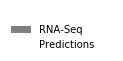

In [26]:
fig = figure(figsize=(0.4,0.25))
ax = fig.add_subplot(111)
ax.bar([1],[1],color='gray',label='RNA-Seq')
ax.bar([1],[1],color='w',label='Predictions')
leg = ax.legend(bbox_to_anchor=(0.5,0.5))
leg.get_frame().set_alpha(0)
box('off')
ax.tick_params(labelsize=0,size=0)
ax.axis([100,101,100,101])
ax.grid('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])

if SAVEFIGS:
    name = '/ExamplePredictions/Legend'
    fig.savefig(figdir+name+'.png', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+name+'.eps', bbox_inches='tight',dpi=300)
    fig.savefig(figdir+name+'.pdf', bbox_inches='tight',dpi=300)

In [27]:
for i in np.random.choice(test_inds,3):
    make_nt_contribution_fig_5(i,SAVEFIGS)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  after removing the cwd from sys.path.


NameError: global name 'score_seq' is not defined

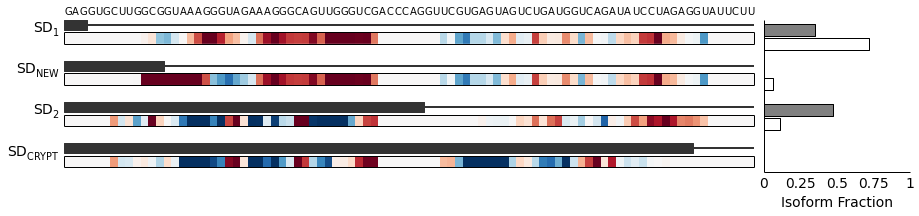

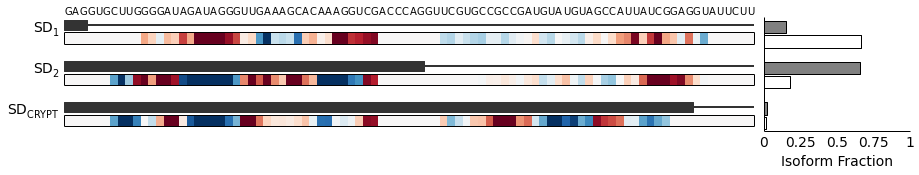

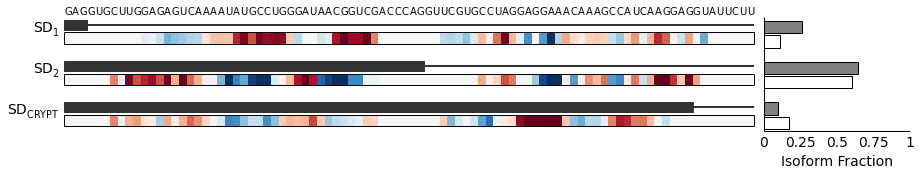

In [204]:
for i in np.random.choice(test_inds,3):
    make_nt_contribution_fig_4(i,SAVEFIGS)